# Morphen: Multi-Sersic Image Fitting Decomposition for Optical Data
`morphen`, is a collection of python tools for astronomical image analysis. <br>

Author: Geferson Lucatelli <br>
email: geferson.lucatelli@postgrad.manchester.ac.uk <br>
email2: gefersonlucatelli@gmail.com<br>
Code Version: 0.3 <br>
Codename: Pelicoto <br>

The main goal is to use a combination of Sersic functions to model the brightness emission of an astronomical image, as robust as possible and as simplified as possible. At the end, the full decomposition can be achieved simply by running two notebook cells. 

The code uses GPU acceleration when available (through `JaX`), thus fast.
The implementation is semi-automated, as in the current stage, it requires the user to specify if a detected structure of emission is mono-component or multi-component. 

Specific details can be found here: 
[`image_decomposition/README.md`](https://github.com/lucatelli/morphen/blob/main/image_decomposition/README.md)


Multiple libraries, functions, etc, are placed in the library file: 
[`morphen/libs/libs.py`](https://github.com/lucatelli/morphen/blob/main/libs/libs.py).


The module [`morphen/morphen.py`](https://github.com/lucatelli/morphen/blob/main/morphen.py)
helps to deal with different kinds of tasks. You can run it on a notebook (or as a `CLI`, but still experimental).

Development Warning: The fitting implementation for optical images is in an early testing stage. The code base is exactly the same as the one used for radio interferometric images, which is more stable. 

For optical images, we require a better evaluation of the background rms maps, source cleaning, finding, etc. 
This will be improved in the near future. 



## Importing 

In [1]:
import sys
sys.path.append('../libs/')
sys.path.append('../')
import morphen as mp
import libs as mlibs
import numpy as np

def reload_libs():
    import libs as mlibs
    from importlib import reload
    reload(mlibs)
    import morphen as mp
    reload(mp)


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
   Radio Morphen              |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

# Reading the Data: IMAGE 2D and PSF 2D

In [4]:
# root_path = '../../data_examples_dev/optical/efigi/lenticulars/showcase/'
psf_root_path = '../../data_examples_dev/optical/efigi/'
# imagename = root_path + 'PGC0032452_r.fits'
# imagename = root_path + 'PGC0060343_r_seg.fits' #use this for the showcase
root_path = '../../data_examples_dev/optical/efigi/lenticulars/barred/showcase/'
imagename = root_path + 'PGC0049408_r_seg.fits' #use this for the showcase
psf_name = psf_root_path+'psf_efigi_s13.fits'

In [11]:
#using the built-in function to read the data
input_data=mp.read_data(filename=imagename,
                        psfname=psf_name)

++>> Image File: PGC0049408_r_seg.fits
-->> No Residual File was provided.
++>> PSF File: psf_efigi_s13.fits


In [12]:
input_data

We can plot these images. I am going to use the help function called `mlibs.eimshow`.

<Axes: xlabel='Offset [px]', ylabel='Offset [px]'>

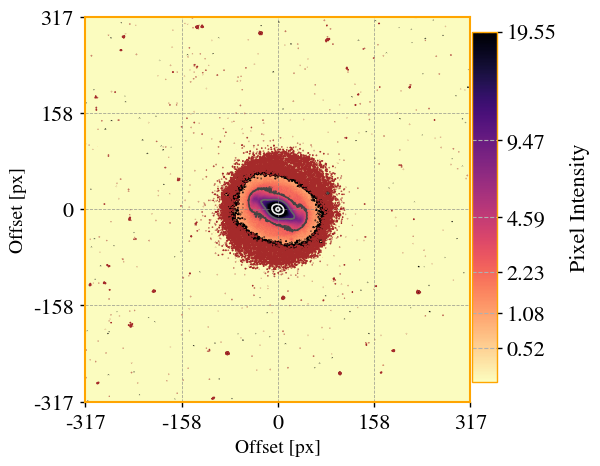

In [13]:
mlibs.eimshow(input_data.filename,crop=False,
              vmax_factor=0.1,
              with_wcs=True,
              vmin_factor=2,
              box_size=200,flux_units='any',
              projection='px')

## Source Extraction
Now, it is time to prepare ourselves for the image fitting. 

Before we head to the Sérsic fitting, we should inspect the structure of the emission. 
For that, we can perform a simple source extraction from the image and compute basic prior information, which includes:

1. Finding relevant regions of emission, and applying deblending where required. We will have the locations `(x0,y0)` of these regions.
2. Then, we compute first order sizes and effective intensities of these regions, for example $R_{50}$, $I_{50}$ and, additionally the Petrosian radius $R_{\rm p}$ (experimental).
3. It is also relevant to quantify the axis ratio $q=b/a$ and position angles $PA$ of these structures. 

We use this prior information to construct a physically constrained Sérsic model. 

Note however that, necessarily, we do not require accurate shape properties from these individual regions. We are looking for initial physical constraints for our model, and those quantities will be optimised during minimisation.

To do this, we use the class `mp.source_extraction`, which allow us to find relevant regions of emission and determine our prior information. Only after that, one should proceed to the Sérsic fitting. 

Let's load our data again, if required.

### Testing the Source-Extraction
The source extraction uses the `SEP` or the `PetroFit` packages. `SEP` is a python implementation of the SExtractor algorithm (Bertin & Arnouts 1996), see (https://sep.readthedocs.io/en/v1.1.x/). To select which one one wants to use, use the argument `algorithm='SEP'` or `algorithm='PF'` in the class `mp.source_extraction`.

Note that the usage of these utilities require more testing across different images (radio > optical). The default parameters may work well or not depending of your data, due to image size, artefacts, SNR, etc. 

You will need to play with the parameters below until you are happy with the detection. 
Parameters that are critical for the source detection/extractions are summarised below:
```
- bwf : int
    Box width fraction in terms of the beam size
    for the background estimation.
- bhf : int
    Box height fraction in terms of the beam size
    for the background estimation.
- fwf : int
    Filter width fraction in terms of the beam size
    for the background estimation.
- fhf : int
    Filter height fraction in terms of the beam size
    for the background estimation.
- deblend_nthresh : int (this is nlevels in Photutils)
    Number of thresholds used for object deblending. 
    Default is 32.
- deblend_nthresh : int (this is nlevels in Photutils)
    Number of thresholds used for object deblending. 
    Default is 32.
- clean_param : float (unique to SEP)
    Cleaning parameter for the source extraction.
    Default is 1.0.
- deblend_cont : float (this is contrast in Photutils)
    Minimum contrast ratio used for object deblending. Default is 0.005.
    
```

WARNING: This is implementation is in an early stage, so it is not completely automated. It is required that the user interacts with it in order to check if the source detection is feasible. That usually involves, from the default parameters below, run the source extraction in the image and check if it went well. If not (e.g. false detections, artefacts, etc), play around with the parameters until okay. 
Improvements are being made so that this can be escalated to multiple images. We also are planing to include AstroDendro and PyBDSF capabilities for this task of source detection in future updates.


Lets now run a source extraction in our image to extract relevant information. 


In [14]:
"""
bwf, bhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!
fwf, fhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!
clean_param = 0.5
deblend_cont = 1e-2
deblend_nthresh = 3
sigma_mask = 60
sigma = 50
ell_size_factor = 20
"""

'\nbwf, bhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!\nfwf, fhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!\nclean_param = 0.5\ndeblend_cont = 1e-2\ndeblend_nthresh = 3\nsigma_mask = 60\nsigma = 50\nell_size_factor = 20\n'

In [17]:
#this is a set of parameters that may work OKAY
bwf, bhf = 2, 2 # standard value that works for a wide range of images. But, additional check is required!!!!
fwf, fhf = 2, 2 # standard value that works for a wide range of images. But, additional check is required!!!!
clean_param = 0.5
deblend_cont = 1e-2
deblend_nthresh = 64
sigma_mask = 6
sigma = 10
ell_size_factor = 2
minarea_factor = 5

### Check Source Detection/Extraction Results with a 'dry run'.
We first run a source extraction in 'dry run' mode (setting `dry_run=True`) to check how many regions are detected.
In this mode, no photometry will be performed, just the regions will be displayed.

This mode is good to check if the detection went well given the parameters used (defined previously).

+++++++++++++++++++++++
SEP Filter sizes:
    bw,bh=( 63 63 )
    fw,fh=( 31 31 )
+++++++++++++++++++++++
INFO: Total number of Sources/Structures (deblended) =  1


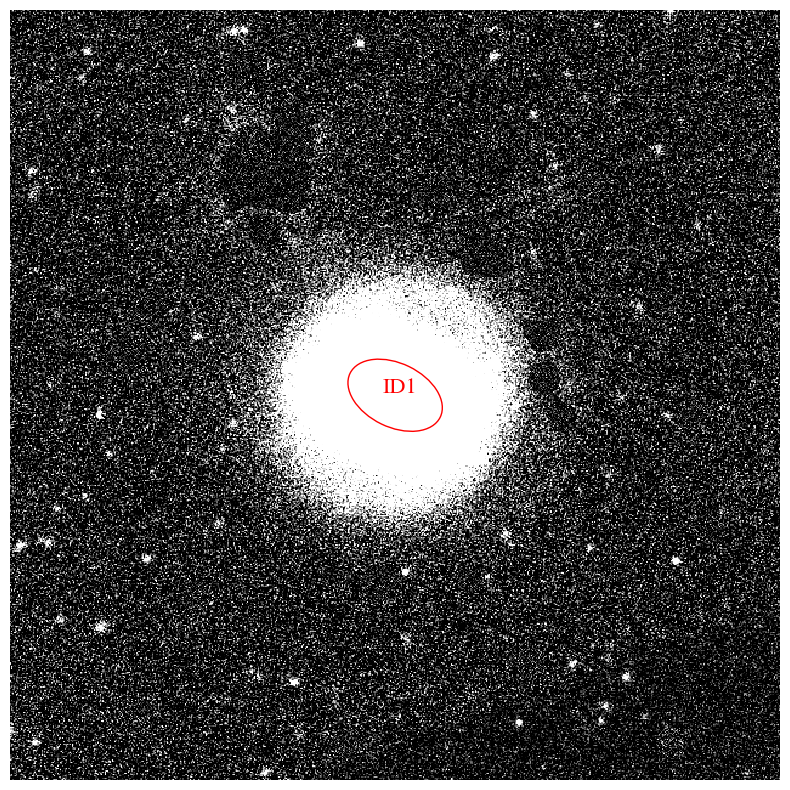

In [18]:

SE = mp.source_extraction(input_data, 
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=minarea_factor,
                          apply_mask=False,sigma_mask=sigma_mask,dilation_size=3,
                          show_petro_plots=True,algorithm='SEP',
                          dry_run=True, obs_type = 'other')
# plt.imshow(input_data.image_data_2D)

If you are happy with the results, you can set `dry_run=False` and photometry will be performed in the data. 

Another very important part is related to the argument `ids_to_add`. This is a list to specify which detected region 
requires more than one component to be fitted to the data. Think this as a bulge+disk decomposition. 
The whole emission will be detected as a single region, but it is clear that we need to model it as two components (bulge+disk).
In our case, we have only one structure, `ID1`. But, by inspection of the data, we see that our lenticular galaxy in this example is more 
complex than that. We see the bulge, a circumnuclear structure and a more extended disk in the outer edges. 

In this example, one would set `ids_to_add=['1','2']` to indicate that the region `ID1` needs two extra components to be fitted.

Lets review this by each case. When `ids_to_add=['1']` is set, it means that a new component will be added to the region `ID1`, so now 
`COMP_1` and `COMP_2`. The initial size parameters (and boundaries) will be larger than the initial size parameters of `COMP_1` (currently, the factor is 3).

When `ids_to_add=['1','2']` is set, it means that one component will be added to the region `ID1` 
and another component will be indexed to `COMP_2`. This will impose that the initial size parameters of `COMP_3` is larger than 
`COMP_2` (and also `COMP_1`), i.e. `COMP_1 < COMP_2 < COMP_3`. We can also specify `ids_to_add=['1','1']`, so two components will be added to the region `ID1`, 
but both (`COMP_2` and `COMP_3`) will have similar initial size parameters, i.e. `COMP_1 < COMP_2 = COMP_3`.

This is the manual part of the Sersic fitting within `morphen`. 

***We are working in a strategy to automate this process in future releases.***



Input image is not a string.
+++++++++++++++++++++++
SEP Filter sizes:
    bw,bh=( 63 63 )
    fw,fh=( 31 31 )
+++++++++++++++++++++++
INFO: Total number of Sources/Structures (deblended) =  1


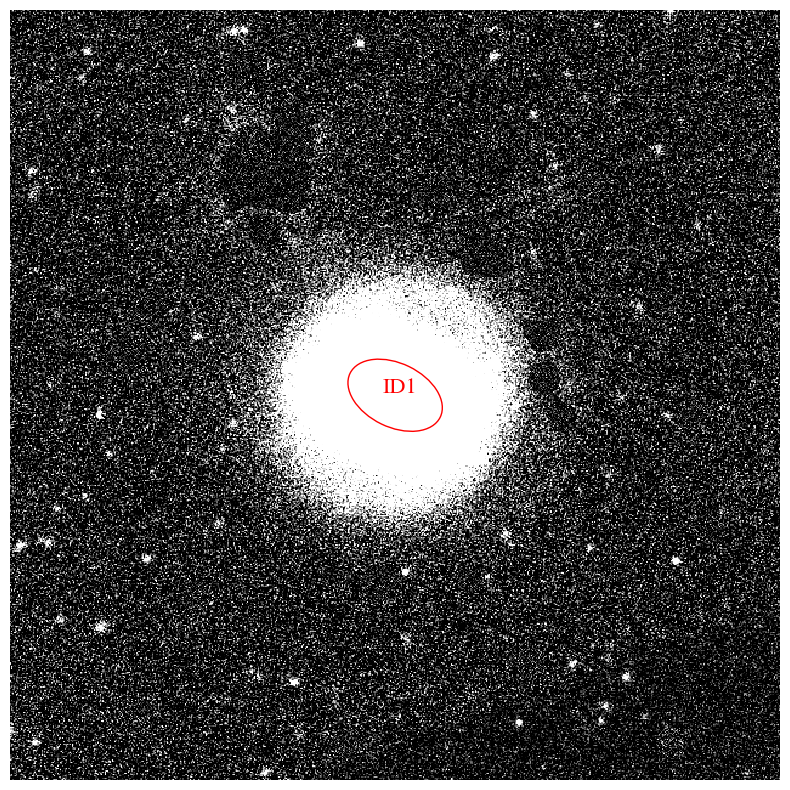

1


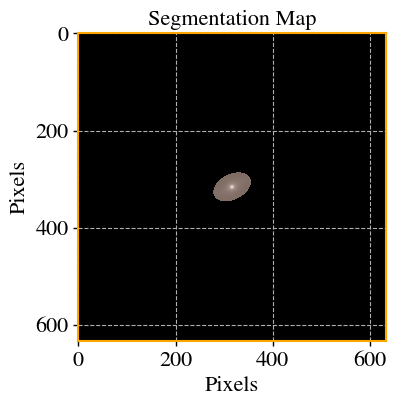

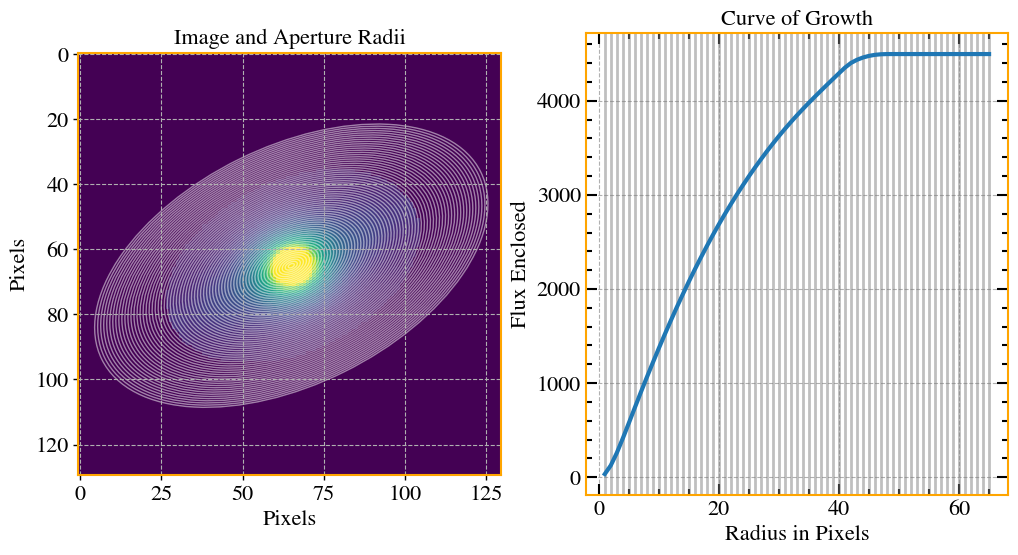

1


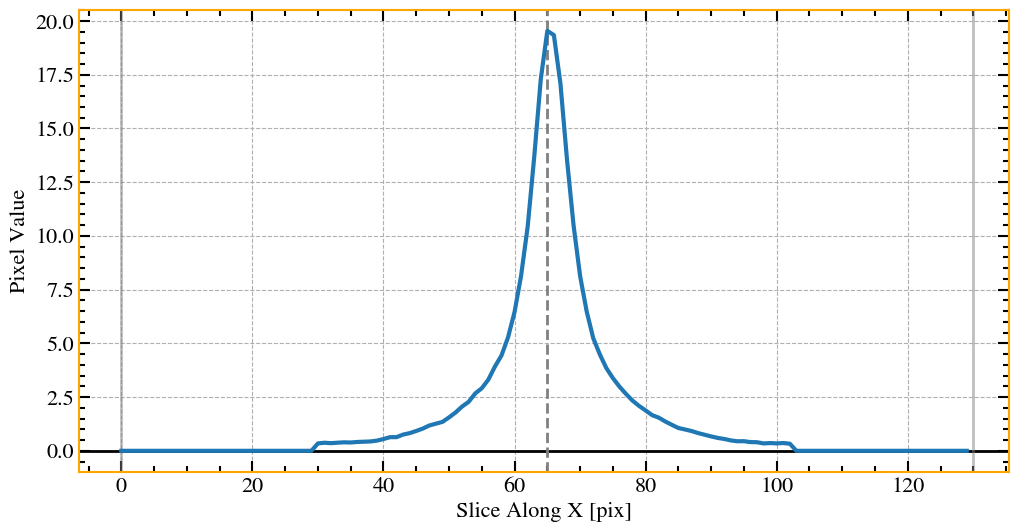

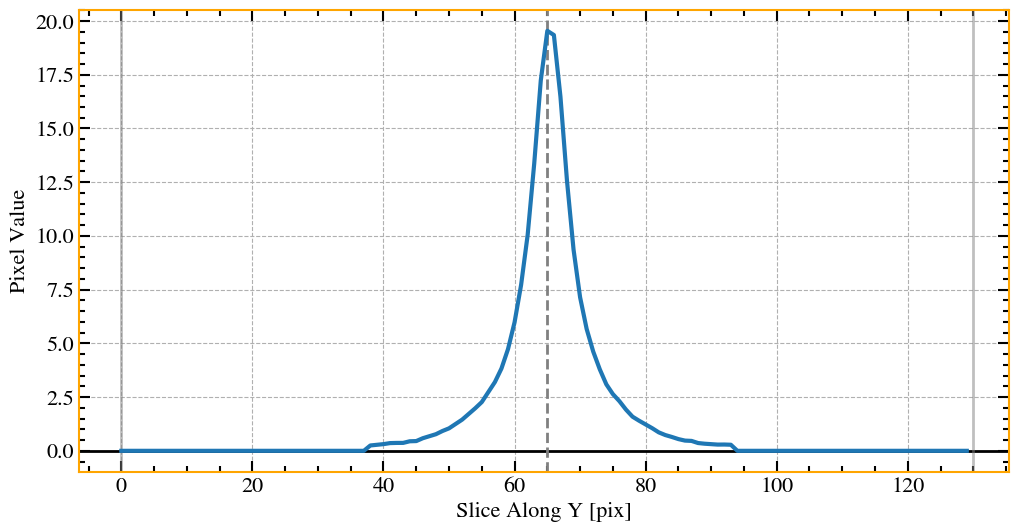

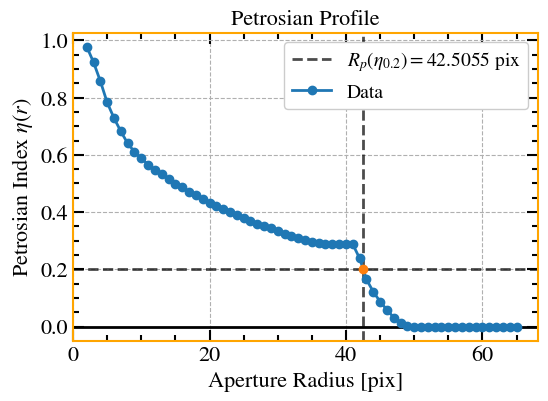

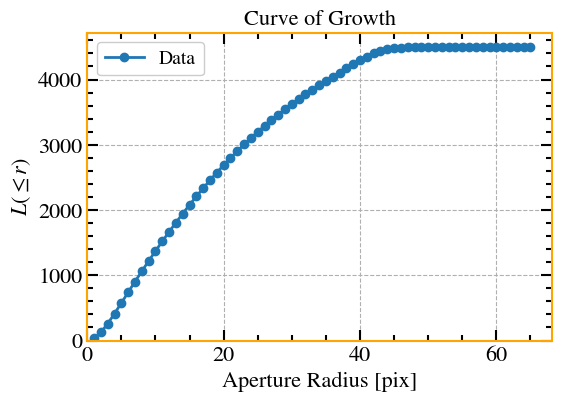

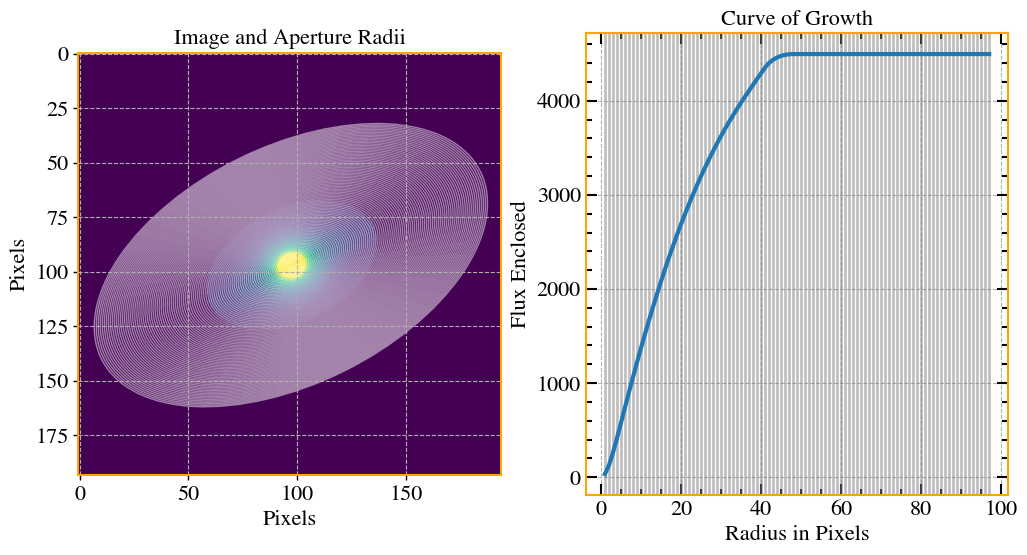

# of structures (IDs) to be fitted = 1
# of model components (COMPS) to be fitted = 3


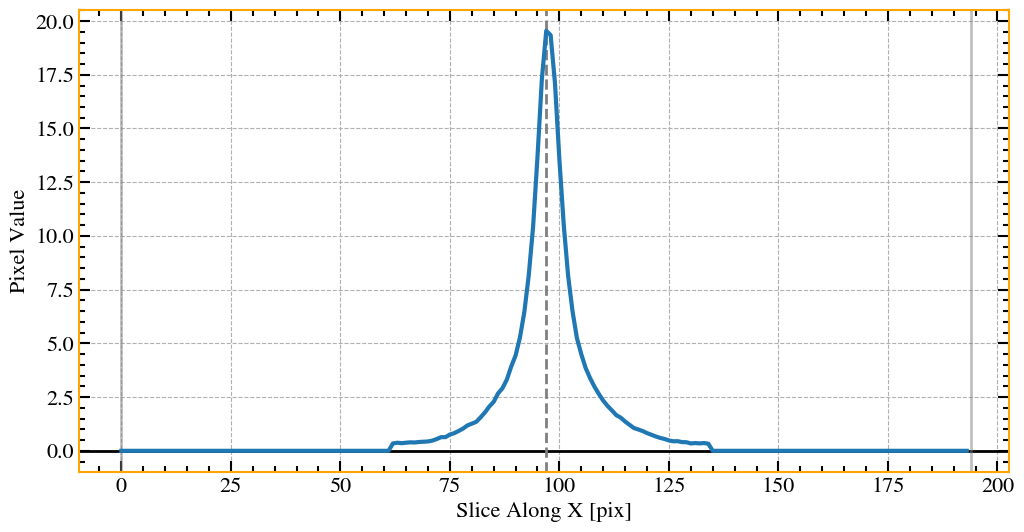

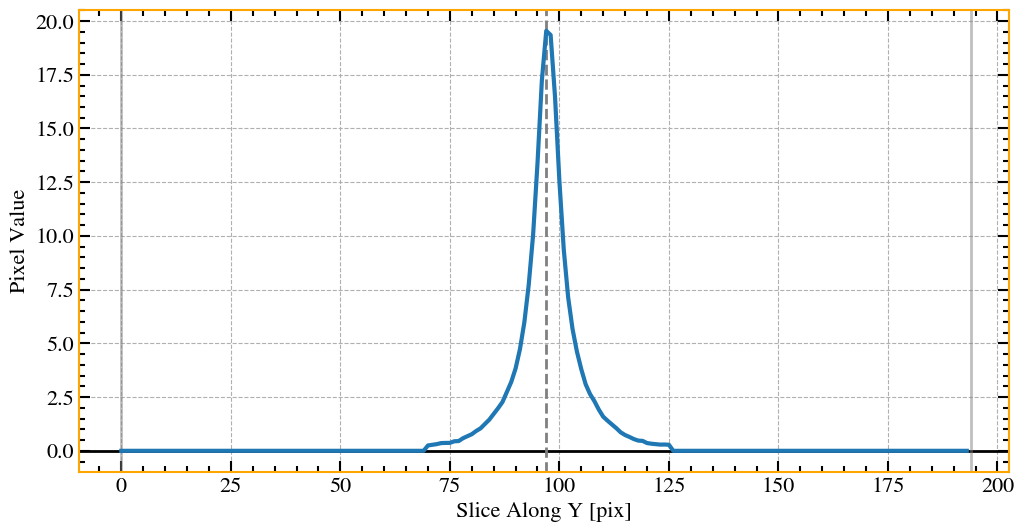

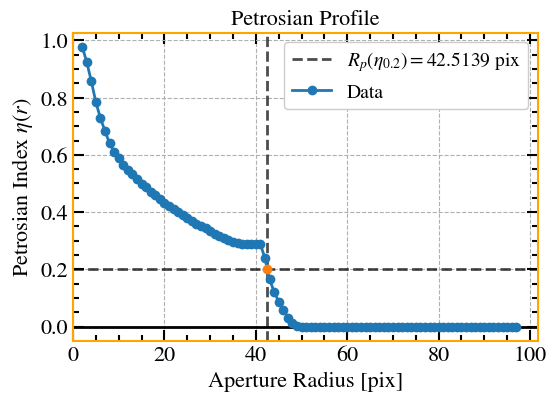

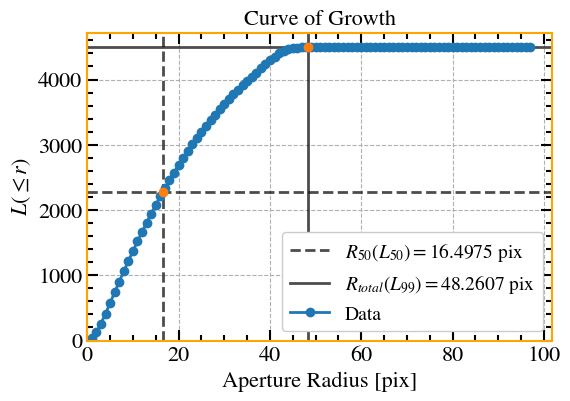

In [19]:
SE = mp.source_extraction(input_data, ids_to_add=['1','2'],
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf=bwf, bhf=bhf, fwf=fwf, fhf=fhf,
                          clean_param=clean_param, 
                          deblend_cont=deblend_cont, minarea_factor=minarea_factor,
                          deblend_nthresh=deblend_nthresh,
                          apply_mask=False,sigma_mask=sigma_mask,
                          show_petro_plots=True,obs_type = 'other',algorithm='SEP',
                          dry_run=False)

In [20]:
SE.sources_photometries

{'c1_PA': -26.287062920134,
 'c1_q': 0.5608226962445215,
 'c1_area': 3400.0,
 'c1_Re': 32.897623212397704,
 'c1_x0c': 316.55569802231514,
 'c1_y0c': 316.3278849774936,
 'c1_label': 1,
 'c1_R50': 16.49749949989998,
 'c1_R20': 7.049209841968394,
 'c1_R80': 30.113022604520904,
 'c1_C1': 0.6306139112461953,
 'c1_Snu': 4496.521318947368,
 'c1_Rp': 42.513902780556116,
 'c1_Rpidx': 85,
 'c1_rlast': 97,
 'c1_I50': 1.2311923125137885,
 'ncomps': 3,
 'c2_PA': -26.287062920134,
 'c2_q': 0.5608226962445215,
 'c2_area': 3400.0,
 'c2_Re': 32.897623212397704,
 'c2_x0c': 316.55569802231514,
 'c2_y0c': 316.3278849774936,
 'c2_label': 1,
 'c2_R50': 49.49249849969994,
 'c2_R20': 7.049209841968394,
 'c2_R80': 30.113022604520904,
 'c2_C1': 0.6306139112461953,
 'c2_Snu': 4496.521318947368,
 'c2_Rp': 42.513902780556116,
 'c2_Rpidx': 85,
 'c2_rlast': 97,
 'c2_I50': 0.12311923125137886,
 'c3_PA': -26.287062920134,
 'c3_q': 0.5608226962445215,
 'c3_area': 3400.0,
 'c3_Re': 32.897623212397704,
 'c3_x0c': 316.555

In [21]:
for i in range(1,SE.sources_photometries['ncomps']+1):
    print(f"(R50, I50) COMP_{i} = ({SE.sources_photometries['c'+str(i)+'_R50']:.2f},{SE.sources_photometries['c'+str(i)+'_I50']:.4f})")


(R50, I50) COMP_1 = (16.50,1.2312)
(R50, I50) COMP_2 = (49.49,0.1231)
(R50, I50) COMP_3 = (148.48,0.0123)


#### We have now basic properties of each component of our radio emission:
- `x0 `  : x-coordinate centre position
- `y0 `  : y-coordinate centre position
- `q  `  : axis ratio
- `PA `  : position angle
- `Snu`  : total flux (sum of pixels)
- `Re `  : effective circular area radii 
- `Rp `  : Petrosian Radius
- `R50 ` : half-light radius
- `I50 ` : effective intensity (I at R50)

These parameters will be used to feed the initial hints for the Sersic Decomposition

### Background estimations

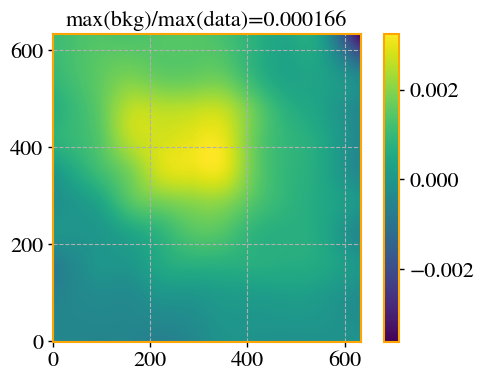

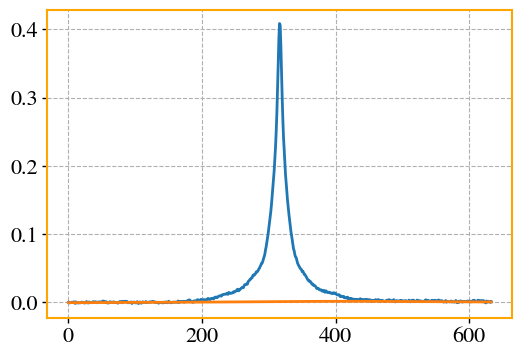

In [22]:
sep_bkg = mlibs.sep_background(input_data.filename,show_map=True,
                               bw=64, 
                               bh=64, 
                               fw=int(7), 
                               fh=int(7))
mlibs.plt.figure()
mlibs.plt.plot(np.mean(input_data.image_data_2D,axis=1))
mlibs.plt.plot(np.mean(sep_bkg.back(),axis=1))
# mlibs.plt.semilogy()
# mlibs.plt.ylim(-1e-5,1e-4)

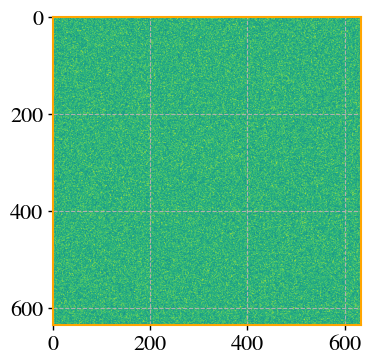

In [23]:
mlibs.plt.imshow(mlibs.shuffle_2D(sep_bkg.back()))

## Multi-Sersic Decomposition

2024-03-22 16:08:58.165351: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:458] TfrtCpuClient created.
2024-03-22 16:08:58.235228: I external/xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:910] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 16:08:58.235448: I external/xla/xla/service/service.cc:168] XLA service 0x587d30a96b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 16:08:58.235474: I external/xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-03-22 16:08:58.235762: I external/xla/xla/pjrt/gpu/se_gpu_pjrt_client.cc:627] Using BFC allocator.
2024-03-22 16:08:58.235797: I external/xla/xla/pjrt/gpu/gpu_helpers.cc:105] XLA backend allocating 2090156032 bytes on device

 ++==>> Limiting x0=316.55569802231514+/-10
 ++==>> Limiting y0=316.3278849774936+/-10
 ++==>> Limiting x0=316.55569802231514+/-10
 ++==>> Limiting y0=316.3278849774936+/-10
Using general elliptical geometry during fitting... may take longer.
 ++==>> Limiting x0=316.55569802231514+/-10
 ++==>> Limiting y0=316.3278849774936+/-10
{'f1_x0': {'value': 316.55569802231514, 'min': 306.55569802231514, 'max': 326.55569802231514}, 'f1_y0': {'value': 316.3278849774936, 'min': 306.3278849774936, 'max': 326.3278849774936}, 'f1_PA': {'value': -26.287062920134, 'min': -116.287062920134, 'max': 63.712937079865995}, 'f1_ell': {'value': 0.4391773037554785, 'min': 0.0878354607510957, 'max': 0.75}, 'f1_n': {'value': 0.5, 'min': 0.3, 'max': 8.0}, 'f1_In': {'value': 1.2311923125137885, 'min': 0.12311923125137886, 'max': 615.5961562568942}, 'f1_Rn': {'value': 16.49749949989998, 'min': 3.2994998999799963, 'max': 24.74624924984997}, 'f1_cg': {'value': 0.0, 'min': -0.01, 'max': 0.01}, 'f2_x0': {'value': 316.555

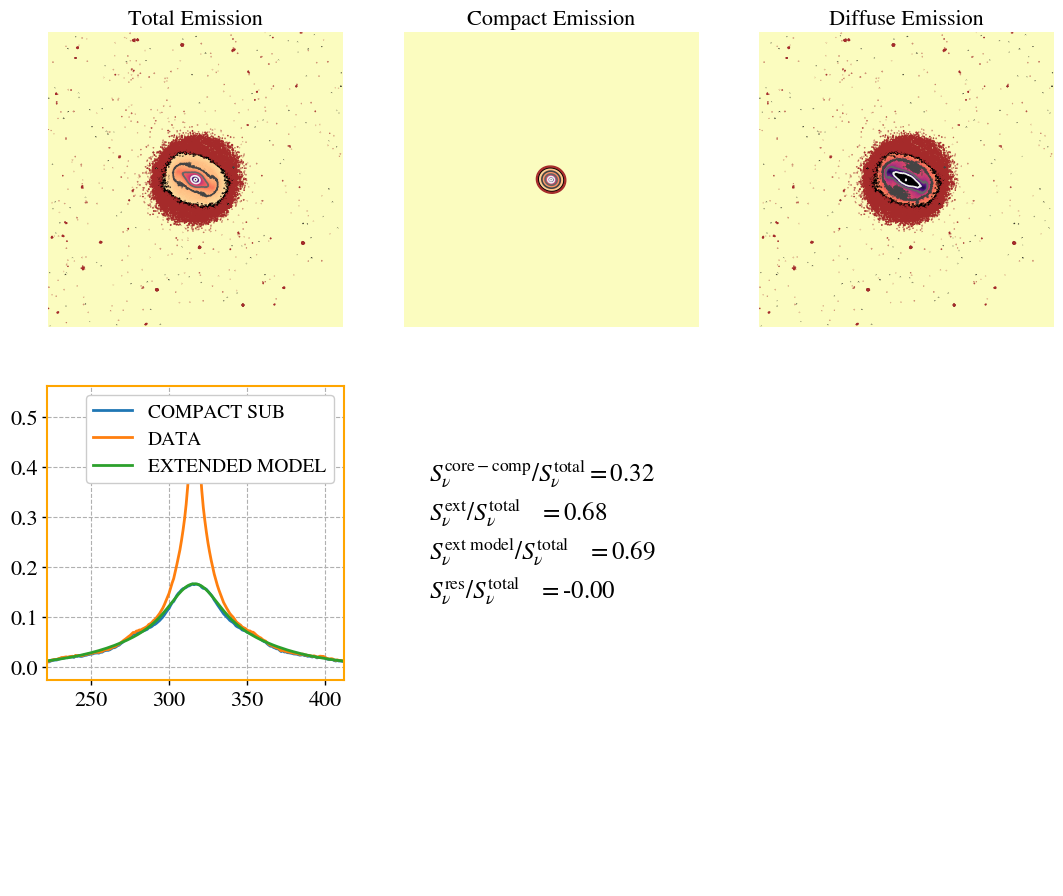

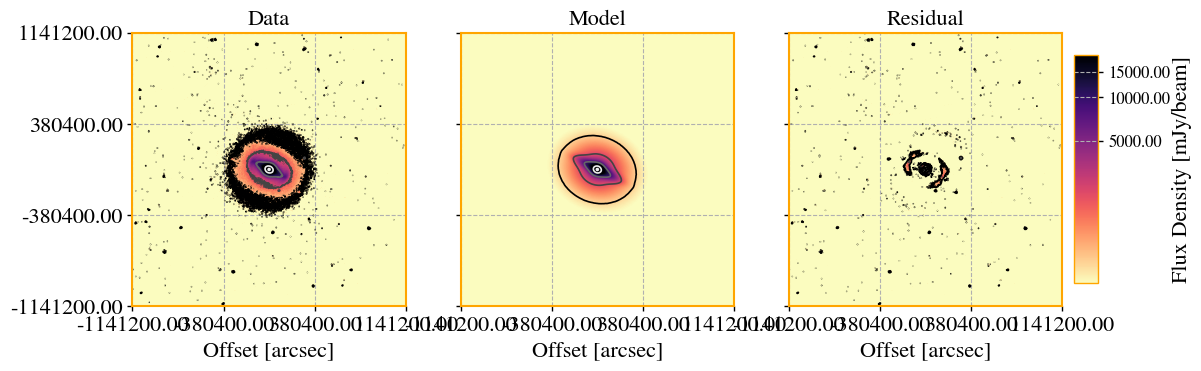

/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:11645: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-7, -0.05 * np.log(ir[0]))


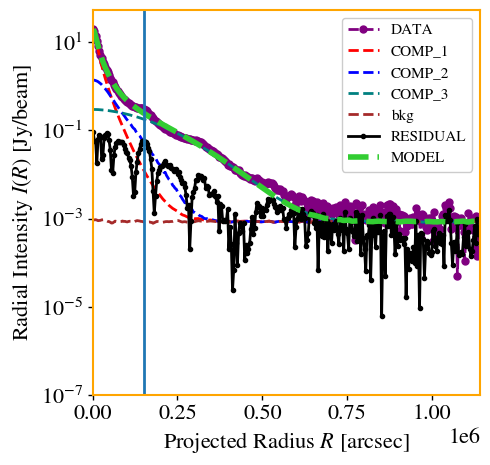

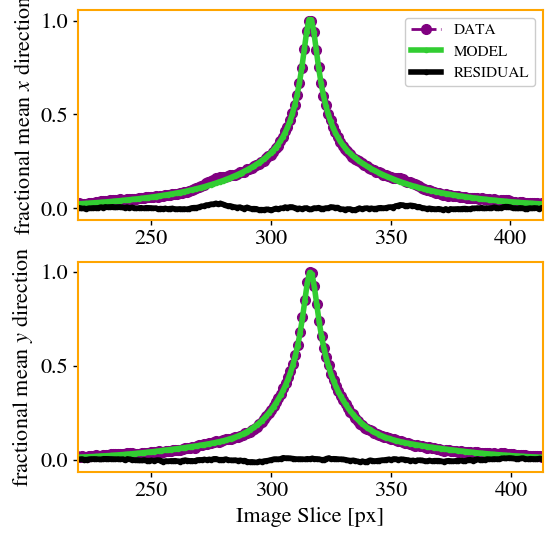

In [24]:
smfg = mp.sersic_multifit_general(input_data,
                                SE, #source extraction object, from previous step
                                convolution_mode='GPU',self_bkg=True,
                                which_residual = 'user',
                                # which_residual = None,
                                bkg_rms_map = mlibs.shuffle_2D(sep_bkg.back()),
                                # mask_for_fit = mask_for_fit,
                                # use_mask_for_fit = False,
                                # bkg_rms_map = sep_bkg.back(),
                                # bkg_rms_map=background_image,
                                tr_solver='exact', #'lsmr or exact'
                                fix_geometry=[True,False,True], #for stability purposes, keep True for now. 
                                comp_ids=['1'],# which component label is compact/bulge?
                                dr_fix=[5,5,300],#for each component, radial element size to fix (x0,y0) positions
                                fix_value_n=[1.0,0.3,1.0],#for each component, the Sersic index value to be fixed. 
                                fix_n=[False,False,False],#for each component, fix or not the Sersic index. 
                                z = 0.1 #just an arbitrary value for now.
                                )

In [25]:
smfg.result_mini.params

Parameters([('f1_x0', <Parameter 'f1_x0', value=316.2318858417922 +/- 0.00101, bounds=[306.55569802231514:326.55569802231514]>), ('f1_y0', <Parameter 'f1_y0', value=316.13057177784816 +/- 0.000984, bounds=[306.3278849774936:326.3278849774936]>), ('f1_PA', <Parameter 'f1_PA', value=-16.61702876898307 +/- 0.178, bounds=[-116.287062920134:63.712937079865995]>), ('f1_ell', <Parameter 'f1_ell', value=0.08783546085086902 +/- 0.000729, bounds=[0.0878354607510957:0.75]>), ('f1_n', <Parameter 'f1_n', value=1.6667469946157056 +/- 0.00519, bounds=[0.3:8.0]>), ('f1_In', <Parameter 'f1_In', value=2.7589031415768646 +/- 0.0222, bounds=[0.12311923125137886:615.5961562568942]>), ('f1_Rn', <Parameter 'f1_Rn', value=7.896937807714287 +/- 0.064, bounds=[3.2994998999799963:24.74624924984997]>), ('f1_cg', <Parameter 'f1_cg', value=0.009999999900125409 +/- 0.00416, bounds=[-0.01:0.01]>), ('f2_x0', <Parameter 'f2_x0', value=316.3920146874753 +/- 0.0203, bounds=[306.55569802231514:326.55569802231514]>), ('f2_y0', <Parameter 'f2_y0', value=316.0386637756219 +/- 0.0115, bounds=[306.3278849774936:326.3278849774936]>), ('f2_PA', <Parameter 'f2_PA', value=-26.55998036749538 +/- 0.0212, bounds=[-116.287062920134:63.712937079865995]>), ('f2_ell', <Parameter 'f2_ell', value=0.7078131131641254 +/- 0.000996, bounds=[0.0878354607510957:0.75]>), ('f2_n', <Parameter 'f2_n', value=0.4521984742171938 +/- 0.00268, bounds=[0.3:8.0]>), ('f2_In', <Parameter 'f2_In', value=0.799087522928977 +/- 0.00548, bounds=[0.012311923125137887:61.55961562568943]>), ('f2_Rn', <Parameter 'f2_Rn', value=20.13100241870613 +/- 0.382, bounds=[9.89849969993999:74.23874774954992]>), ('f2_cg', <Parameter 'f2_cg', value=-0.19245862921059678 +/- 0.00916, bounds=[-2.0:2.0]>), ('f3_x0', <Parameter 'f3_x0', value=315.8312921420572 +/- 0.0622, bounds=[306.55569802231514:326.55569802231514]>), ('f3_y0', <Parameter 'f3_y0', value=315.75797753314265 +/- 0.0511, bounds=[306.3278849774936:326.3278849774936]>), ('f3_PA', <Parameter 'f3_PA', value=-20.620756948670856 +/- 0.265, bounds=[-116.287062920134:63.712937079865995]>), ('f3_ell', <Parameter 'f3_ell', value=0.16611028400350245 +/- 0.00157, bounds=[0.0878354607510957:0.75]>), ('f3_n', <Parameter 'f3_n', value=0.5605709537351986 +/- 0.0043, bounds=[0.3:8.0]>), ('f3_In', <Parameter 'f3_In', value=0.1361190463732764 +/- 0.000966, bounds=[0.0012311923125137888:6.155961562568943]>), ('f3_Rn', <Parameter 'f3_Rn', value=59.83937701511415 +/- 1.49, bounds=[29.69549909981997:222.71624324864973]>), ('f3_cg', <Parameter 'f3_cg', value=0.009999999900371866 +/- 0.0107, bounds=[-0.01:0.01]>), ('s_a', <Parameter 's_a', value=1.0099999999015135 +/- 0.0361, bounds=[0.99:1.01]>)])

Text(0.5, 1.0, 'Data')

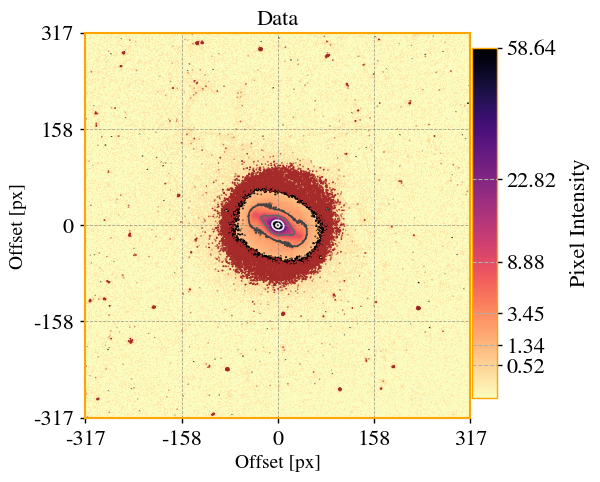

In [27]:
# center = nd.maximum_position(input_data.image_data_2D)
center = (int(smfg.result_mini.params['f1_x0'].value),int(smfg.result_mini.params['f1_y0'].value))
rms = mlibs.mad_std(mlibs.ctn(input_data.filename))
ax = mlibs.eimshow(input_data.filename,
                   projection='px',vmin_factor=0.10,
                   crop=False,box_size=80,vmax_factor=0.1,flux_units='any',
             vmax=input_data.image_data_2D.max()*0.3,
                   rms=rms)
ax.set_title('Data')

Text(0.5, 1.0, 'Diffuse Emission')

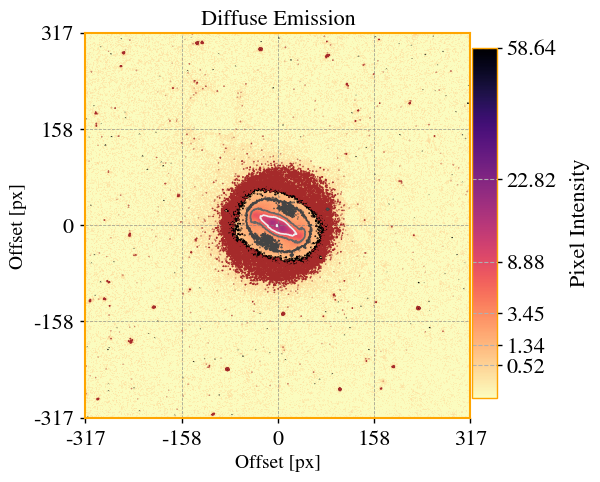

In [28]:
ax = mlibs.eimshow(input_data.image_data_2D-\
                   smfg.model_dict['model_c1_conv'],
                   projection='px',vmin_factor=0.10,center=center,
                   crop=False,box_size=80,vmax_factor=0.1,flux_units='any',
                   vmax=input_data.image_data_2D.max()*0.3,
                   rms=rms)
ax.set_title('Diffuse Emission')

Text(0.5, 1.0, 'Compact Deconvolved')

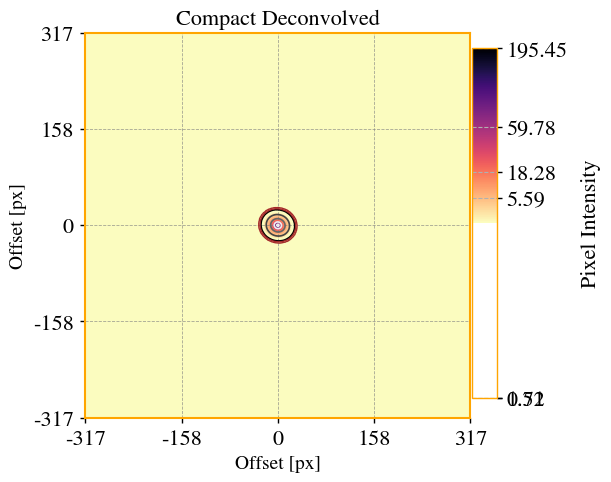

In [29]:
ax=mlibs.eimshow(smfg.model_dict['model_c1'],
                   projection='px',vmin_factor=10.0,center=center,
                   crop=False,box_size=80,vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Compact Deconvolved')

Text(0.5, 1.0, 'Compact Convolved')

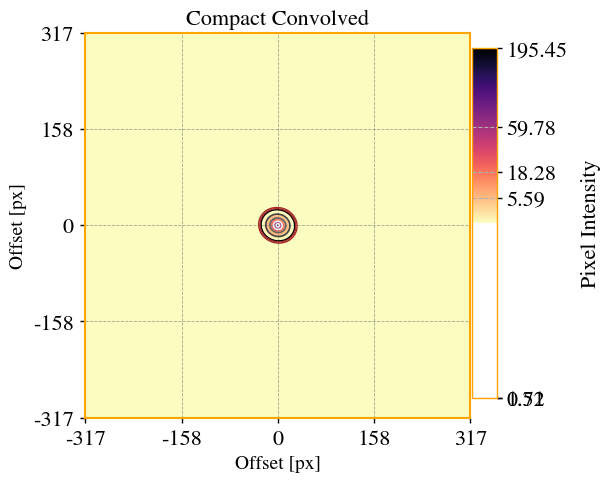

In [30]:
ax=mlibs.eimshow(smfg.model_dict['model_c1_conv'],
                   projection='px',vmin_factor=10.0,center=center,
                   crop=False,box_size=80,vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Compact Convolved')

In [35]:
# ax=mlibs.eimshow(smfr.model_dict['model_c2'],
#                    projection='px',vmin_factor=0.10,center=center,
#                    crop=True,box_size=80,vmax_factor=0.09,flux_units='any',
#                    vmax=input_data.image_data_2D.max(),
#                    rms=rms)
# ax.set_title('Compact Deconvolved')

Text(0.5, 1.0, 'Model Deconvolved')

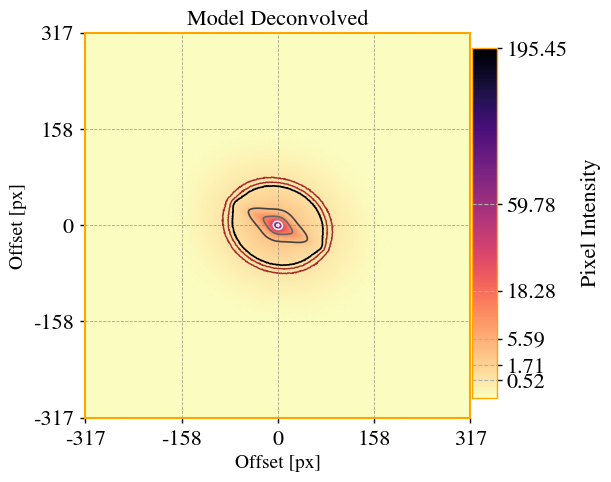

In [31]:
ax=mlibs.eimshow(smfg.model_dict['model_total_dec'],
                   projection='px',vmin_factor=0.10,center=center,
                   crop=False,box_size=80,vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Model Deconvolved')

Text(0.5, 1.0, 'Model Convolved')

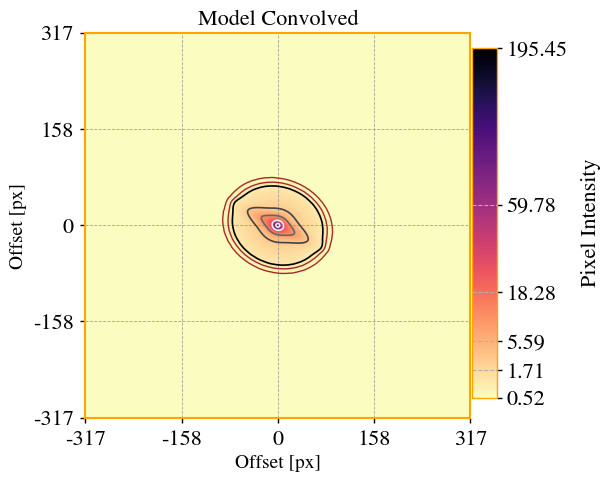

In [32]:
ax=mlibs.eimshow(smfg.model_dict['model_total_conv'],
                   projection='px',vmin_factor=3.0,center=center,
                   crop=False,box_size=80,vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Model Convolved')

Text(0.5, 1.0, 'Residual')

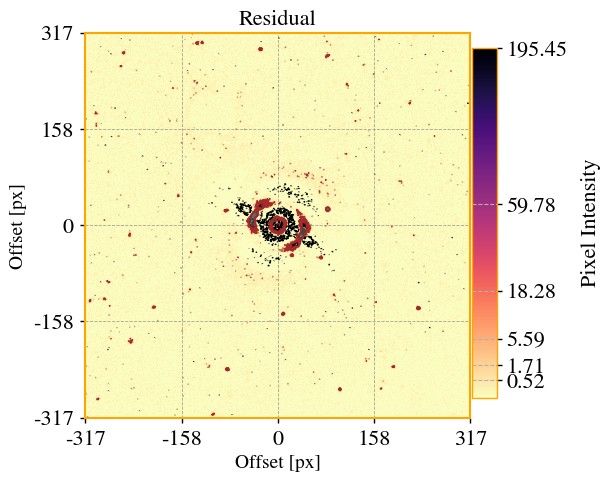

In [33]:
ax = mlibs.eimshow(input_data.image_data_2D- smfg.model_dict['model_total_conv'],
                   projection='px',vmin_factor=0.10,center=center,
                   crop=False,box_size=80,vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Residual')

Text(0.5, 1.0, 'Residual (no vmax)')

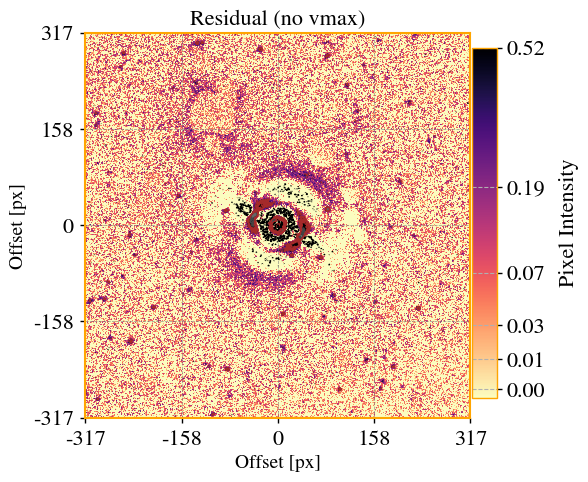

In [34]:
ax = mlibs.eimshow(input_data.image_data_2D- smfg.model_dict['model_total_conv'],
                   projection='px',vmin_factor=3.0,center=center,
                   crop=False,box_size=80,
                   vmax_factor=1.0,flux_units='any',
                   vmax=np.mean(input_data.image_data_2D- smfg.model_dict['model_total_conv']),
                   rms=rms)
ax.set_title('Residual (no vmax)')